In [1]:
# 我们在车杆环境中进行 REINFORCE 算法的实验

import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 定义策略网络PolicyNet，其输入是某个状态，输出则是该状态下的动作概率分布，这里采用在离散动作空间上的softmax()函数来实现一个可学习的多项分布（multinomial distribution）

class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

定义 REINFORCE 算法。在函数take_action()函数中，我们通过动作概率分布对离散的动作进行采样。

在更新过程中，我们按照算法将损失函数写为策略回报的负数 $-\sum_{t}\psi_{t}\nabla_{\theta}log\;\pi_{\theta}(a_t|s_t)$

对 $\theta$ 求导后就可以通过梯度下降来更新策略

In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device) # 策略网络
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device

    def take_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device) 
        probs = self.policy_net(state) # 计算动作概率分布
        action_dist = torch.distributions.Categorical(probs) # 构建一个多项分布，多项分布描述了一组离散型随机变量各出现的概率
        action = action_dist.sample() # 采样
        return action.item() 

    def update(self, transition_dict): # 更新策略网络
        reward_list = transition_dict['rewards'] # 
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0 # 累积回报
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):  # 从后往前遍历经验数据是REINFORCE算法中的一个重要步骤，它可以确保我们计算的策略梯度是正确的，并且可以保证我们的策略网络能够收敛到最优策略
            reward = reward_list[i] # 当前步的回报
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device) # 当前步的状态
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device) # 当前步的动作
            log_prob = torch.log(self.policy_net(state).gather(1, action)) # 当前步的动作概率
            G = self.gamma * G + reward # 更新累积回报
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度
        self.optimizer.step()  # 梯度下降

In [4]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/envs/registration.py:592: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/lizhiyuan/miniconda3/envs/ATSC/lib/python3.9/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(s

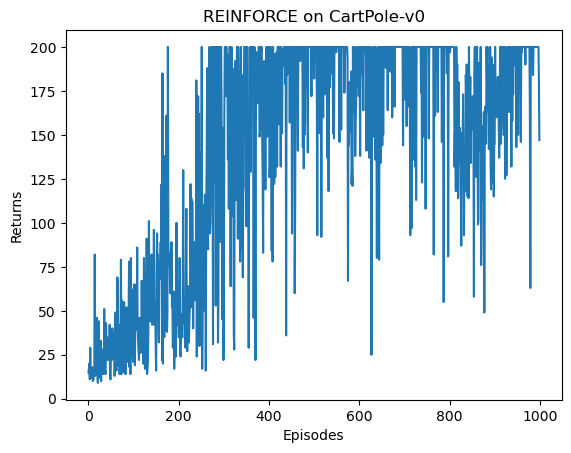

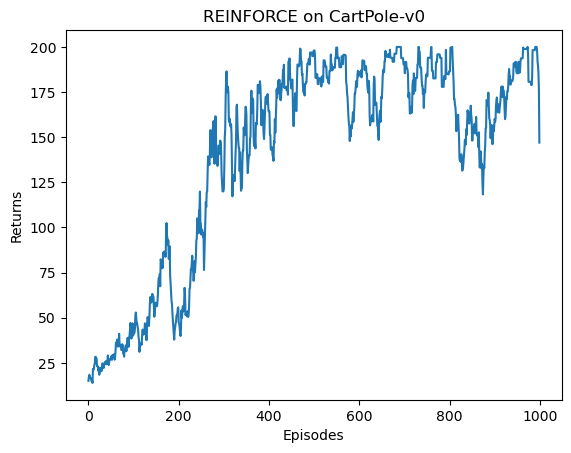

In [5]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()